## Initial setup

In [ ]:
import tensorflow as tf
print(tf.__version__)

2.3.0


In [ ]:
!nvidia-smi

Sun Oct  4 05:20:35 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.23.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   54C    P8    10W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install -q wandb

     |████████████████████████████████| 1.7MB 4.5MB/s 
     |████████████████████████████████| 102kB 12.8MB/s 
     |████████████████████████████████| 102kB 12.3MB/s 
     |████████████████████████████████| 122kB 18.3MB/s 
     |████████████████████████████████| 163kB 17.5MB/s 
     |████████████████████████████████| 71kB 10.0MB/s 


In [ ]:
# Other imports
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
import matplotlib.pyplot as plt
from imutils import paths
from tqdm import tqdm
import tensorflow as tf
import numpy as np
import cv2

# Random seed fixation
tf.random.set_seed(666)
np.random.seed(666)

# Initialize wandb
import wandb
wandb.init()
from wandb.keras import WandbCallback

<IPython.core.display.Javascript object>

wandb: You can find your API key in your browser here: https://wandb.ai/authorize


wandb: Paste an API key from your profile and hit enter: ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


## Dataset gathering and preparation

In [ ]:
# Gather dataset
!git clone https://github.com/thunderInfy/imagenet-5-categories

Cloning into 'imagenet-5-categories'...
remote: Enumerating objects: 1532, done.
remote: Total 1532 (delta 0), reused 0 (delta 0), pack-reused 1532
Receiving objects: 100% (1532/1532), 88.56 MiB | 50.89 MiB/s, done.
Resolving deltas: 100% (1/1), done.


In [ ]:
# Train and test image paths
train_images = list(paths.list_images("imagenet-5-categories/train"))
test_images = list(paths.list_images("imagenet-5-categories/test"))
print(len(train_images), len(test_images))

1250 250


In [ ]:
def prepare_images(image_paths):
    images = []
    labels = []

    for image in tqdm(image_paths):
        image_pixels = plt.imread(image)
        image_pixels = cv2.resize(image_pixels, (224, 224))
        image_pixels = image_pixels/255.

        label = image.split("/")[2].split("_")[0]

        images.append(image_pixels)
        labels.append(label)

    images = np.array(images)
    labels = np.array(labels)

    print(images.shape, labels.shape)

    return images, labels

In [ ]:
X_train, y_train = prepare_images(train_images)
X_test, y_test = prepare_images(test_images)

  9%|▉         | 23/250 [00:00<00:01, 223.83it/s]

(1250, 224, 224, 3) (1250,)


100%|██████████| 250/250 [00:01<00:00, 212.38it/s]


(250, 224, 224, 3) (250,)


In [ ]:
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

In [ ]:
# Set up TensorFlow dataset for performance optimization

AUTO = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 64

train_ds = (
    tf.data.Dataset.from_tensor_slices((X_train, y_train_enc))
    .shuffle(1024)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

test_ds = (
    tf.data.Dataset.from_tensor_slices((X_test, y_test_enc))
    .shuffle(1024)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

## Utilities

In [ ]:
# Architecture utils
def get_resnet(trainable=True):
    base_model = tf.keras.applications.ResNet50(include_top=False, weights=None, input_shape=(224, 224, 3))
    base_model.trainable = trainable

    inputs = Input((224, 224, 3))
    features = base_model(inputs, training=True)
    pooled_features = GlobalAveragePooling2D()(features)

    outputs = Dense(5, activation="softmax")(pooled_features)

    resnet_simclr = Model(inputs, outputs)

    return resnet_simclr

In [ ]:
def plot_training(H):
	with plt.xkcd():
		plt.plot(H.history["loss"], label="train_loss")
		plt.plot(H.history["val_loss"], label="val_loss")
		plt.plot(H.history["accuracy"], label="train_acc")
		plt.plot(H.history["val_accuracy"], label="val_acc")
		plt.title("Training Loss and Accuracy")
		plt.xlabel("Epoch #")
		plt.ylabel("Loss/Accuracy")
		plt.legend(loc="lower left")
		plt.show()

## Training

In [ ]:
# Early Stopping to prevent overfitting
es = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=2, verbose=2, restore_best_weights=True)

In [ ]:
get_resnet(trainable=True).summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 5)                 10245     
Total params: 23,597,957
Trainable params: 23,544,837
Non-trainable params: 53,120
_________________________________________________________________


In [ ]:
# Initialize wandb
wandb.init(entity="g-simclr", project="g-simclr", id="imagenet-s-supervised")

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


Epoch 1/200
20/20 [==============================] - 17s 855ms/step - loss: 2.5718 - accuracy: 0.4096 - val_loss: 1.2545 - val_accuracy: 0.5280
Epoch 2/200
20/20 [==============================] - 15s 767ms/step - loss: 1.2218 - accuracy: 0.5392 - val_loss: 1.2051 - val_accuracy: 0.5440
Epoch 3/200
20/20 [==============================] - 13s 644ms/step - loss: 1.1248 - accuracy: 0.5848 - val_loss: 1.4714 - val_accuracy: 0.5200
Epoch 4/200
20/20 [==============================] - 14s 714ms/step - loss: 1.0637 - accuracy: 0.6304 - val_loss: 1.0287 - val_accuracy: 0.5840
Epoch 5/200
20/20 [==============================] - 15s 732ms/step - loss: 0.8696 - accuracy: 0.6792 - val_loss: 0.8866 - val_accuracy: 0.6760
Epoch 6/200
20/20 [==============================] - 13s 665ms/step - loss: 0.8355 - accuracy: 0.6904 - val_loss: 0.9482 - val_accuracy: 0.6560
Epoch 7/200
20/20 [==============================] - 13s 670ms/step - loss: 0.7519 - accuracy: 0.7176 - val_loss: 0.9447 - val_accuracy:

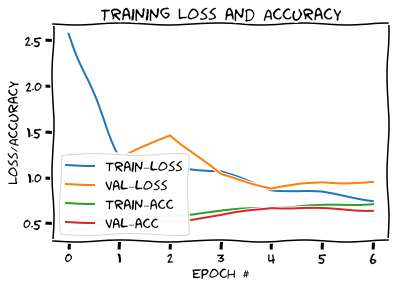

In [ ]:
# Train the supervised model with full data
model = get_resnet()
model.compile(loss="sparse_categorical_crossentropy", metrics=["accuracy"],
              optimizer=tf.keras.optimizers.Adam())
history = model.fit(train_ds,
                    validation_data=test_ds,
                    epochs=200,
                    callbacks=[es, WandbCallback()])
plot_training(history)